In [1]:
import torch
import torchvision
import torch.nn as nn
from torch import optim
from torchvision import transforms, datasets, models
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.optim import lr_scheduler

from sklearn.model_selection import KFold
from skimage import io

import os

from PIL import Image, ImageOps
import numpy as np
from numpy.random import default_rng
import pandas as pd
import matplotlib.pyplot as plt
import copy
import time

import warnings
warnings.filterwarnings('ignore')

plt.ion()

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# NOTE**
80 normal and 58 tubeculosis

# Mount to Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Copy Tubeculosis Data

In [4]:
!cp -a ./drive/MyDrive/MontgomerySet .

# Declare File Paths

In [5]:
work_dir =  '/content/MontgomerySet/'
xray_pic_dir = os.path.join(work_dir, 'CXR_png/')
right_mask_dir = os.path.join(work_dir, 'ManualMask/rightMask/')
left_mask_dir = os.path.join(work_dir, 'ManualMask/leftMask')
clinical_readings_dir = os.path.join(work_dir, 'ClinicalReadings')

# Try Loading Data

### Pre-Dataset Classes

In [ ]:
class TubeImageDataset(Dataset):   # Tube is tubeculosis

    @staticmethod
    def make_imgname_df(root_dir):
        df = pd.DataFrame({'img_name': []})
        valid_file_type = ('png')
        for base, dirs, files in os.walk(root_dir):
            for file_name in files:
                file_type = file_name.split('.')[-1]
                if file_type  in valid_file_type:
                    df = df.append({'img_name': file_name}, ignore_index=True)

        return df

    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_df = self.make_imgname_df(root_dir)

    def __len__(self):
        return len(self.image_df)

    def __getitem__(self, idx):
        img_name = self.image_df.iloc[idx]['img_name']
        img_path = os.path.join(self.root_dir, img_name)
        image = io.imread(img_path, as_gray=True)
        label = img_name[12]
        
        if self.transform:
            image = self.transform(image)
        
        sample = {'image': image, 'label': label}

        return sample

In [ ]:
class CRDataset:  # Clinical Readings Dataset

    @staticmethod
    def map_data(lines):
        mapped_value = dict()
        sex_line = lines[0]
        age_line = lines[1]
        result = lines[2]
        sex = sex_line.split(': ')[-1].replace('\n', '').replace(' ', '')
        age = age_line.split(': ')[-1].replace('\n', '').replace(' ', '')
        result = result.replace('\n', '')
        age = int(age[:-1])
        mapped_value['sex'] = sex
        mapped_value['age'] = age
        mapped_value['result'] = result
        return mapped_value

    @staticmethod
    def make_df(root_dir):
        df = pd.DataFrame()
        read_mode = 'r' # read only
        for base, dirs, files in os.walk(root_dir):
            for file_name in files:
                file_path = os.path.join(root_dir, file_name)

                with open(file_path, read_mode) as f:
                    lines = f.readlines()

                new_data = CRDataset.map_data(lines)
                new_data['case_name'] = file_name.split('.')[0]
                df = df.append(new_data, ignore_index=True)

        df = df.sort_values(by=['case_name'], ignore_index=True)
        return df

    def __init__(self, root_dir, transform=None):
        self.transform = transform   # transform should be custom one
        self.df = CRDataset.make_df(root_dir)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        sample_df = self.df.iloc[idx]
        print(sample_df['result'])
        sample = {'age': sample_df['age'], 'sex': sample_df['sex'], 'result': 0 if sample_df['result'] == 'normal' else 1}
        
        if self.transform:
            transform(sample)

        return sample

In [ ]:
xray_img_dataset = TubeImageDataset(xray_pic_dir)
left_mask_img_dataset = TubeImageDataset(left_mask_dir)
right_mask_img_dataset = TubeImageDataset(right_mask_dir)

In [ ]:
cr_dataset = CRDataset(clinical_readings_dir)

# EDA

In [ ]:
print(f'Count Xray Image Dataset: {len(xray_img_dataset)}')
print(f'Count Left Mask Image Dataset: {len(left_mask_img_dataset)}')
print(f'Count Right Mask Image Dataset: {len(right_mask_img_dataset)}')
print(f'Count Clinical Readings Datast: {len(cr_dataset)}')

Count Xray Image Dataset: 138
Count Left Mask Image Dataset: 138
Count Right Mask Image Dataset: 138
Count Clinical Readings Datast: 138


In [ ]:
df = cr_dataset.df  # pass by reference

In [ ]:
df.head()

,age,case_name,result,sex
0,27.0,MCUCXR_0001_0,normal,F
1,40.0,MCUCXR_0002_0,normal,F
2,21.0,MCUCXR_0003_0,normal,F
3,11.0,MCUCXR_0004_0,normal,F
4,33.0,MCUCXR_0005_0,normal,M


In [ ]:
df.tail()

,age,case_name,result,sex
133,14.0,MCUCXR_0383_1,calcified granuloma LUL behind 4th rib anterior,F
134,42.0,MCUCXR_0387_1,inactive scars RUL,M
135,52.0,MCUCXR_0390_1,Rt apical scarring. LUL scars and some infiltr...,M
136,30.0,MCUCXR_0393_1,left pleural effusion; best seen on lateral vi...,F
137,63.0,MCUCXR_0399_1,large infiltrate RUL with cavitation plus infi...,F


In [ ]:
def get_k_intervals(min_v, max_v, k):
    step = (max_v - min_v) / k
    return ([step*i + min_v for i in range(k)], [step*(i+1) + min_v for i in range(k)])

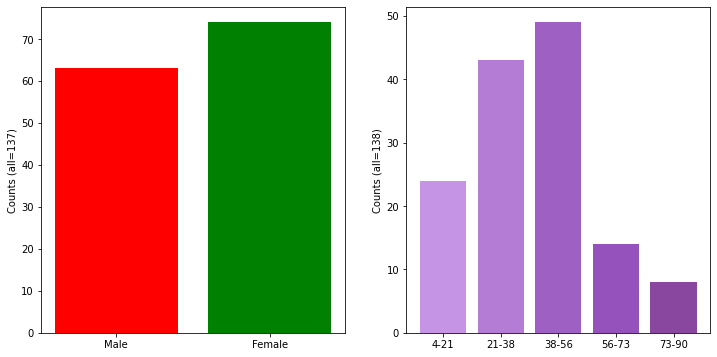

In [ ]:
fig, (sex_ax, age_ax) = plt.subplots(1, 2, figsize=(12, 6))

### show sex data ### 

sex_df = df['sex']
n_male, n_female = sex_df[sex_df == 'M'].count(), sex_df[sex_df == 'F'].count()
sex_heights = [n_male, n_female]
sex_bars = ['Male', 'Female']

sex_ypos = np.arange(len(sex_bars))
sex_ax.bar(sex_ypos, sex_heights, color=['red', 'green'])
sex_ax.set_xticks(sex_ypos)
sex_ax.set_xticklabels(sex_bars)
sex_ax.set_ylabel(f'Counts (all={sum(sex_heights)})')

### show age data ###

age_df = df['age']
n_interval = 5
min_v, max_v = age_df.min(), age_df.max()
lbound, ubound = get_k_intervals(min_v, max_v+1, n_interval)
age_heights = list()
for lb, ub in zip(lbound, ubound):
    interval_count = age_df[(age_df >= lb) & (age_df < ub)].count()
    age_heights.append(interval_count)
age_bars = [f'{lbound[i]:.0f}-{ubound[i]:.0f}' for i in range(len(lbound))]

age_color = np.array([(198, 148, 228),
             (180, 124, 212),
             (159, 96, 196),
             (149, 81, 188),
             (138, 71, 159)]) / 255

age_ypos = np.arange(len(age_bars))
age_ax.bar(age_ypos, age_heights, color=age_color)
age_ax.set_xticks(age_ypos)
age_ax.set_xticklabels(age_bars)
age_ax.set_ylabel(f'Counts (all={sum(age_heights)})')

fig.show()

In [ ]:
df[df['sex'] =='O']  ## outlier

,age,case_name,result,sex
59,5.0,MCUCXR_0080_0,normal,O


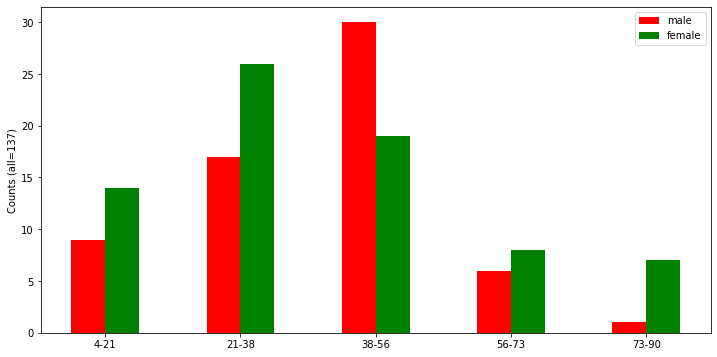

In [ ]:
### show age by gender ###
age_df = df['age']
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
male_age_df, female_age_df = df[df['sex'] == 'M']['age'], df[df['sex'] == 'F']['age']

n_interval = 5
min_v, max_v = age_df.min(), age_df.max()
lbound, ubound = get_k_intervals(min_v, max_v+1, n_interval)
age_bars = [f'{lbound[i]:.0f}-{ubound[i]:.0f}' for i in range(len(lbound))]
width = 0.25

# male data here
male_age_heights = list()
for lb, ub in zip(lbound, ubound):
    interval_count = male_age_df[(age_df >= lb) & (age_df < ub)].count()
    male_age_heights.append(interval_count)
male_age_color = ['red']*len(male_age_heights)
male_age_ypos = np.arange(len(male_age_heights))

ax.bar(male_age_ypos, male_age_heights, color=male_age_color, width=width)

# female data here
female_age_heights = list()
for lb, ub in zip(lbound, ubound):
    interval_count = female_age_df[(age_df >= lb) & (age_df < ub)].count()
    female_age_heights.append(interval_count)
female_age_color = ['green']*len(female_age_heights)
female_age_ypos = np.arange(len(female_age_heights)) + width
ax.bar(female_age_ypos, female_age_heights, color=female_age_color, width=width)

# misc
center_ypos = (male_age_ypos + female_age_ypos) / 2
ax.set_xticks(center_ypos)
ax.set_xticklabels(age_bars)
ax.set_ylabel(f'Counts (all={sum(male_age_heights) + sum(female_age_heights)})')
ax.legend(['male', 'female'])
fig.show()

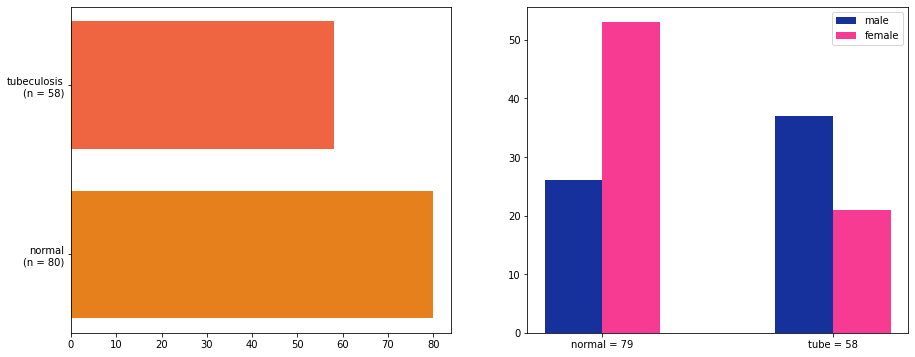

In [ ]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15, 6))

result_df = df['result']
n_normal, n_tube = result_df[result_df == 'normal'].count(), result_df[result_df != 'normal'].count()
result_ypos = np.arange(2)
color = np.array([(230, 128, 28),
                  (239, 101, 66)]) / 255
ax1.barh(result_ypos, [n_normal, n_tube], height=0.75, color=color)
ax1.set_yticks(result_ypos)
ax1.set_yticklabels([f'normal\n(n = {n_normal})', f'tubeculosis\n(n = {n_tube})'])

male_df, female_df = df[df['sex'] == 'M'], df[df['sex'] == 'F']
male_heights = [male_df[male_df['result'] == 'normal']['result'].count(), male_df[male_df['result'] != 'normal']['result'].count()]
female_heights = [female_df[female_df['result'] == 'normal']['result'].count(), female_df[female_df['result'] != 'normal']['result'].count()]
male_color = np.array(2*[(22, 49, 156)]) / 255
female_color = np.array(2*[(247, 59, 147)]) / 255

width = 0.25
result_by_gender_ypos = np.arange(len(male_heights)) - width / 2
ax2.bar(result_by_gender_ypos, male_heights, color=male_color, width=width)
ax2.bar(result_by_gender_ypos+width, female_heights, color=female_color, width=width)

ax2.set_xticks(result_by_gender_ypos + width / 2)
ax2.set_xticklabels([f'normal = {male_heights[0]+female_heights[0]}', f'tube = {male_heights[1]+female_heights[1]}'])
ax2.legend(['male', 'female'])

fig.show()

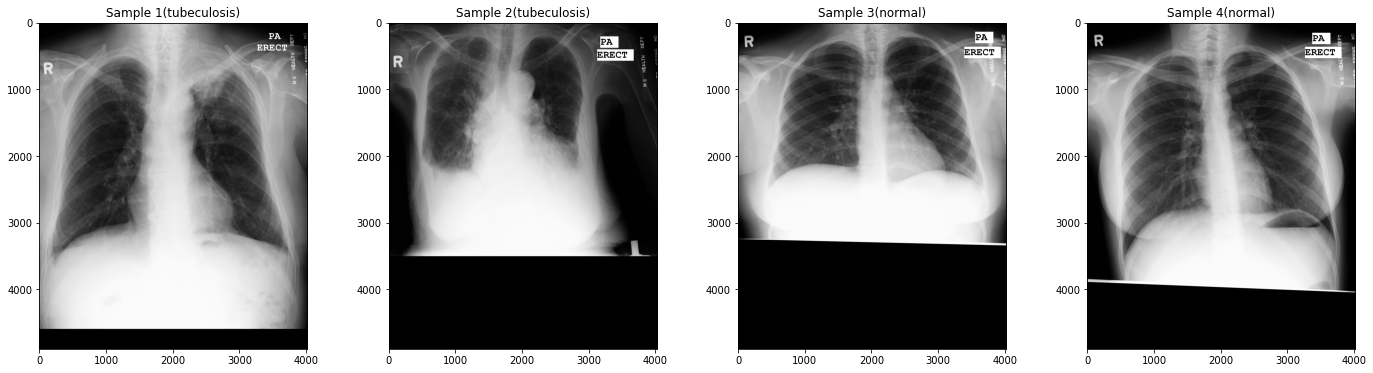

In [ ]:
## random show some data ##
from numpy.random import default_rng

show_width, show_height = 4, 1

rng = default_rng()
rand_idx_list = rng.choice(len(df), show_width*show_height, replace=False)

fig, axs = plt.subplots(show_height, show_width, figsize=(6*show_width, 6*show_height))
for i, idx in enumerate(rand_idx_list):
    xray_img = io.imread(os.path.join(xray_pic_dir, df['case_name'][idx] + '.png'), as_gray=True)
    axs[i].imshow(xray_img, cmap='gray')
    axs[i].set_title(f'Sample {i+1}({"normal" if df["result"][idx] == "normal" else "tubeculosis"})')

fig.show()

# Dataset

In [ ]:
def torch_equalize(image):
    """Implements Equalize function from PIL using PyTorch ops based on:
    https://github.com/tensorflow/tpu/blob/master/models/official/efficientnet/autoaugment.py#L352"""
    def scale_channel(im, c):
        """Scale the data in the channel to implement equalize."""
        im = im[:, :, c]
        # Compute the histogram of the image channel.
        histo = torch.histc(im, bins=256, min=0, max=255)#.type(torch.int32)
        # For the purposes of computing the step, filter out the nonzeros.
        nonzero_histo = torch.reshape(histo[histo != 0], [-1])
        step = (torch.sum(nonzero_histo) - nonzero_histo[-1]) // 255
        def build_lut(histo, step):
            # Compute the cumulative sum, shifting by step // 2
            # and then normalization by step.
            lut = (torch.cumsum(histo, 0) + (step // 2)) // step
            # Shift lut, prepending with 0.
            lut = torch.cat([torch.zeros(1), lut[:-1]]) 
            # Clip the counts to be in range.  This is done
            # in the C code for image.point.
            return torch.clamp(lut, 0, 255)

        # If step is zero, return the original image.  Otherwise, build
        # lut from the full histogram and step and then index from it.
        if step == 0:
            result = im
        else:
            # can't index using 2d index. Have to flatten and then reshape
            result = torch.gather(build_lut(histo, step), 0, im.flatten().long())
            result = result.reshape_as(im)
        
        return result.type(torch.uint8)

    # Assumes RGB for now.  Scales each channel independently
    # and then stacks the result.
    s1 = scale_channel(image, 0)
    image = torch.stack([s1], 2)
    return image

In [75]:
class TubeDataset(Dataset):

    def map_data(self, lines):
        mapped_value = dict()
        sex_line = lines[0]
        age_line = lines[1]
        result = lines[2]
        sex = sex_line.split(': ')[-1].replace('\n', '').replace(' ', '')
        age = age_line.split(': ')[-1].replace('\n', '').replace(' ', '')
        result = result.replace('\n', '')
        age = int(age[:-1])
        mapped_value['sex'] = sex
        mapped_value['age'] = age
        mapped_value['result'] = result
        return mapped_value

    def make_df(self, root_dir):
        df = pd.DataFrame({'img_name': []})
        valid_file_type = ('txt')
        read_mode = 'r'
        for base, dirs, files in os.walk(root_dir):
            for file_name in files:
                file_type = file_name.split('.')[-1]
                if file_type  in valid_file_type:
                    file_path = os.path.join(root_dir, file_name)

                    with open(file_path, read_mode) as f:
                        lines = f.readlines()

                    new_data = self.map_data(lines)
                    new_data['case_name'] = file_name.split('.')[0]
                    df = df.append(new_data, ignore_index=True)

        df = df.sort_values(by=['case_name'], ignore_index=True)
        return df

    def __init__(self, doc_dir, img_dirs, transforms=None):
        self.df = self.make_df(doc_dir)
        self.transforms = transforms
        self.img_dirs = img_dirs

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        sample = dict()
        case_name = self.df['case_name'][idx]
        image_type = 'png'  # magic string
        image_list = list()
        for i, img_dir in enumerate(self.img_dirs):
            img_path = os.path.join(img_dir, case_name + '.' + image_type)
            img = Image.fromarray(io.imread(img_path))
            img = transforms.functional.equalize(img)

            if self.transforms:
                img = self.transforms[i].__call__(img)

            image_list.append(img)
        
        result = self.df['result'][idx]
        label = 0 if result == 'normal' else 1
        sample['images'] = image_list
        sample['label'] = label
        return sample

## show some sample without transform

In [ ]:
tube_dataset = TubeDataset(clinical_readings_dir, [xray_pic_dir, left_mask_dir, right_mask_dir])

30
39
52
15


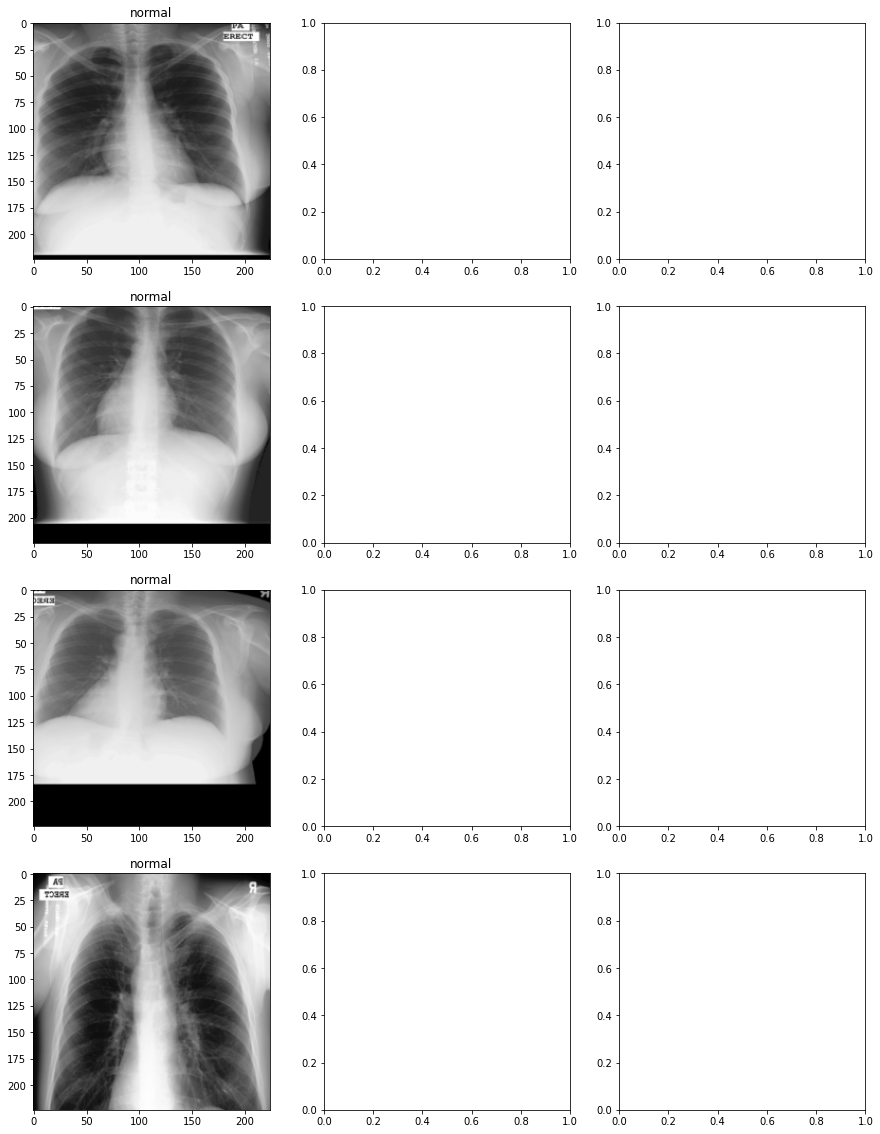

In [77]:
n_show = 4

rng = default_rng()
#rand_idx_list = rng.choice(len(tube_dataset), n_show, replace=False)

fig, axs = plt.subplots(n_show, 3, figsize=(5*3, 5*n_show))
for i, idx in enumerate(rand_idx_list):
    print(idx)
    sample = tube_dataset[idx]
    result = 'normal' if sample['label'] == 0 else 'tubeculosis'
    axs[i][0].set_title(result)
    for j, img in enumerate(sample['images']):
        if type(img) is torch.Tensor:
            size = img.size()
            img = torch.reshape(img, (size[1], size[2]))
        axs[i][j].imshow(img, cmap='gray')
    
fig.show()

# Transformer and Custom Transformer

## implement our custom transformer

In [ ]:
class LeftLungCrop(object):

    def __init__(self, crop_size):
        self.crop_size = crop_size

    def __call__(self, pil_img):
        w, h = pil_img.size
        dh = (h-self.crop_size)//2
        return pil_img.crop((0, dh, self.crop_size, dh+self.crop_size))

class RightLungCrop(object):

    def __init__(self, crop_size):
        self.crop_size = crop_size

    def __call__(self, pil_img):
        w, h = pil_img.size
        dh = (h-self.crop_size)//2
        return pil_img.crop((w-self.crop_size, dh, w, dh+self.crop_size))

## compose our and existing transformer

In [ ]:
train_xray_img_transform = transforms.Compose([
    transforms.Resize((250, 250), interpolation=Image.NEAREST),
    transforms.ColorJitter(brightness=(0.5,1.5), contrast=(1), saturation=(0.5,1.5), hue=(-0.1,0.1)),
    #transforms.RandomResizedCrop((220, 220)),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.225])
])
train_left_lung_img_transform = transforms.Compose([
    transforms.Resize(250),
    LeftLungCrop(220),  # custom transformer
    transforms.ToTensor()
])
train_right_lung_img_transform = transforms.Compose([
    transforms.Resize(250),
    RightLungCrop(220),  # custom transformer
    transforms.ToTensor()
])

### list of transforms
train_transforms = [train_xray_img_transform,
                   train_left_lung_img_transform,
                   train_right_lung_img_transform]

NameError: ignored

In [ ]:
tube_dataset.transforms = train_transforms

## show random transformed imgs

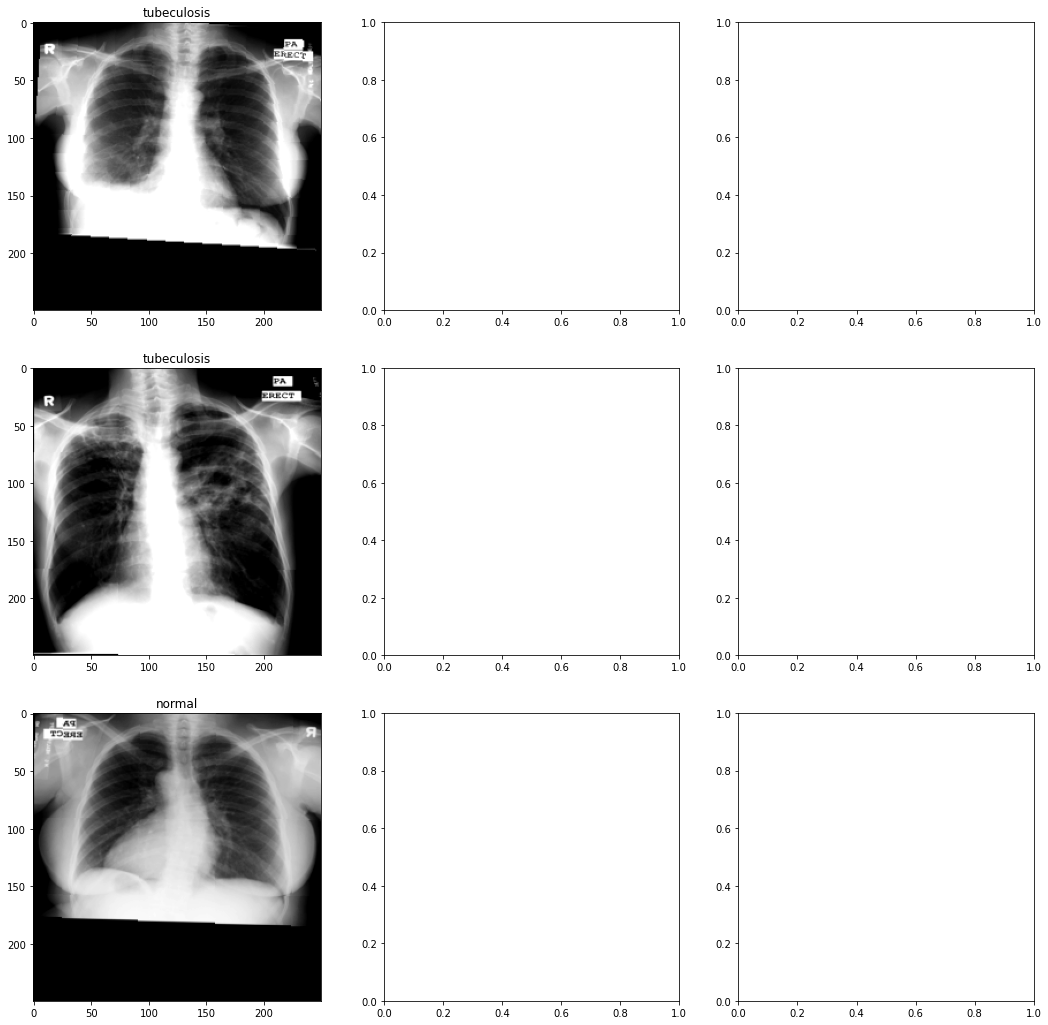

In [ ]:
n_show = 3

rng = default_rng()
rand_idx_list = rng.choice(len(tube_dataset), n_show, replace=False)

fig, axs = plt.subplots(n_show, 3, figsize=(6*3, 6*n_show))
for i, idx in enumerate(rand_idx_list):
    sample = tube_dataset[idx]
    result = 'normal' if sample['label'] == 0 else 'tubeculosis'
    axs[i][0].set_title(result)
    for j, img in enumerate(sample['images']):
        axs[i][j].imshow(img[0], cmap='gray')
    
fig.show()

# Training Function and Validation Function

## combined train val function

In [69]:
def train_n_val(model, criterion, optimizer, scheduler, num_epoch):
    
    train_loss = list()
    val_loss = list()
    train_acc = list()
    val_acc = list()

    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epoch):
        print(f'Epoch {epoch+1}/{num_epoch}')
        print('-'*10)

        train_size = len(train_subsampler)
        running_loss = 0.0
        running_corrects = 0

        model.train()

        for batch in train_dataloader:
            inputs = batch['images'][0]
            labels = batch['label']
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
            
            running_loss += loss.item()*inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        scheduler.step()
        epoch_loss = running_loss / train_size
        epoch_acc = 100* (running_corrects / train_size)
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)
        print('Train Loss: {:.4f} Acc: {:.4f}%'.format(epoch_loss, epoch_acc))

        ## Validation ##
        val_size = len(val_subsampler)
        running_loss = 0.0
        running_corrects = 0

        model.eval()

        for batch in val_dataloader:

            inputs = batch['images'][0]
            labels = batch['label']
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(False):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / val_size
        epoch_acc = 100* (running_corrects / val_size)
        val_loss.append(epoch_loss)
        val_acc.append(epoch_acc)
        print('Valid Loss: {:.4f} Acc: {:.4f}%'.format(epoch_loss, epoch_acc))

        if epoch_acc >= best_acc:
            best_model_wts = copy.deepcopy(model.state_dict())
            best_acc = epoch_acc

    ## Summary ##
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Val Accuracy: {:.4f}%'.format(best_acc))

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    model.load_state_dict(best_model_wts)

    return model, best_acc


# Try ResNet50 with K-Fold Training Pipeline

## DataSets

In [78]:
train_transforms = [transforms.Compose([
    transforms.Resize((250, 250)),
    #transforms.ColorJitter(brightness=(0.8,1.2), contrast=(.5), saturation=(0.5,1.5), hue=(-0.1,0.1)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    #transforms.Normalize([0.485], [0.225])
])]

tube_dataset = TubeDataset(clinical_readings_dir, [xray_pic_dir], transforms=train_transforms)  # used only x-ray pic

## hyperparameters

In [80]:
k = 4
num_epoch = 50
batch_size = 4
num_workers = 4
shuffle_kfold = True
learning_rate = 0.0001

load_previous_model = False

## K-Folds class instance

In [81]:
kfold = KFold(k, shuffle=shuffle_kfold, random_state=42)

## statistical data

In [82]:
train_losses, val_losses = list(), list()
train_accs, val_accs = list(), list()

## pipeline

In [74]:
results = dict()

for fold, (train_ids, val_ids) in enumerate(kfold.split(tube_dataset)):
    if fold > 0:
        break

    ## setup model ##
    model = models.resnet50(pretrained=False)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=0, bias=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)
    model = model.to(device)

    if load_previous_model:
        load_path = f'/content/drive/MyDrive/MontgomeryModel/model-fold-{fold+1}.pth'
        model.load_state_dict(torch.load(load_path))

    ## criterion, optimizer and scheduler ##
    criterion = nn.CrossEntropyLoss()
    optimizer_ft = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=25, gamma=0.1)
    
    ## count each label ##
    normal, tube = 0, 0
    for ids in train_ids:
        result = tube_dataset.df['result'][ids]
        if result == 'normal':
            normal += 1
        else:
            tube += 1
    print('<Train> Normal = {} | Tube = {}'.format(normal, tube))
    normal, tube = 0, 0
    for ids in val_ids:
        result = tube_dataset.df['result'][ids]
        if result == 'normal':
            normal += 1
        else: 
            tube += 1
    print('<Val> Normal = {} | Tube = {}'.format(normal, tube))

    ## training ##
    train_subsampler = SubsetRandomSampler(train_ids)
    val_subsampler = SubsetRandomSampler(val_ids)
    train_dataloader = DataLoader(tube_dataset, batch_size=batch_size, sampler=train_subsampler, num_workers=num_workers)
    val_dataloader = DataLoader(tube_dataset, batch_size=batch_size, sampler=val_subsampler, num_workers=num_workers)

    model, best_acc = train_n_val(model, criterion, optimizer_ft, exp_lr_scheduler, num_epoch)

    results[fold] = best_acc

    save_path = f'/content/drive/MyDrive/MontgomeryModel/model-fold-{fold+1}.pth'
    torch.save(model.state_dict(), save_path)

<Train> Normal = 58 | Tube = 45
<Val> Normal = 22 | Tube = 13
Epoch 1/50
----------
Train Loss: 0.7317 Acc: 52.4272%
Valid Loss: 0.6712 Acc: 62.8571%
Epoch 2/50
----------
Train Loss: 0.6868 Acc: 51.4563%
Valid Loss: 0.6698 Acc: 62.8571%
Epoch 3/50
----------
Train Loss: 0.7012 Acc: 59.2233%
Valid Loss: 0.7103 Acc: 45.7143%
Epoch 4/50
----------
Train Loss: 0.7164 Acc: 49.5146%
Valid Loss: 0.7125 Acc: 48.5714%
Epoch 5/50
----------
Train Loss: 0.6885 Acc: 57.2816%
Valid Loss: 0.6919 Acc: 57.1429%
Epoch 6/50
----------
Train Loss: 0.6733 Acc: 54.3689%
Valid Loss: 0.6912 Acc: 62.8571%
Epoch 7/50
----------
Train Loss: 0.7083 Acc: 62.1359%
Valid Loss: 0.7544 Acc: 42.8571%
Epoch 8/50
----------
Train Loss: 0.7193 Acc: 51.4563%
Valid Loss: 0.6564 Acc: 62.8571%
Epoch 9/50
----------
Train Loss: 0.6705 Acc: 64.0777%
Valid Loss: 0.7964 Acc: 34.2857%
Epoch 10/50
----------
Train Loss: 0.7629 Acc: 50.4854%
Valid Loss: 0.6440 Acc: 62.8571%
Epoch 11/50
----------
Train Loss: 0.6716 Acc: 51.4563%
V

KeyboardInterrupt: ignored

## evaluate graph

In [18]:
def show_result(train_loss, val_loss, train_acc, val_acc):
    fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(12, 6))
    epochs = np.arange(0, num_epoch)+1

    loss_ax.plot(epochs, train_loss, color='orange')
    loss_ax.plot(epochs, val_loss, color='blue')
    loss_ax.set_title('Loss of Each Epoch')
    loss_ax.set_ylabel('Loss')
    loss_ax.set_xlabel('Epochs')
    loss_ax.legend(['Train', 'Val'])

    acc_ax.plot(epochs, train_acc, color='orange')
    acc_ax.plot(epochs, val_acc, color='blue')
    acc_ax.set_title('Accuracy of Each Epoch')
    acc_ax.set_ylabel('Acc(%)')
    acc_ax.set_xlabel('Epochs')
    acc_ax.legend(['Train', 'Val'])

    fig.show()

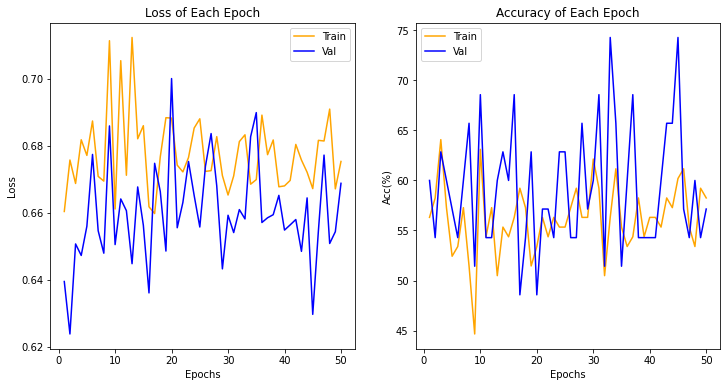

In [21]:
k_to_show = 1 
show_result(train_losses[k_to_show-1], val_losses[k_to_show-1], train_accs[k_to_show-1], val_accs[k_to_show-1])

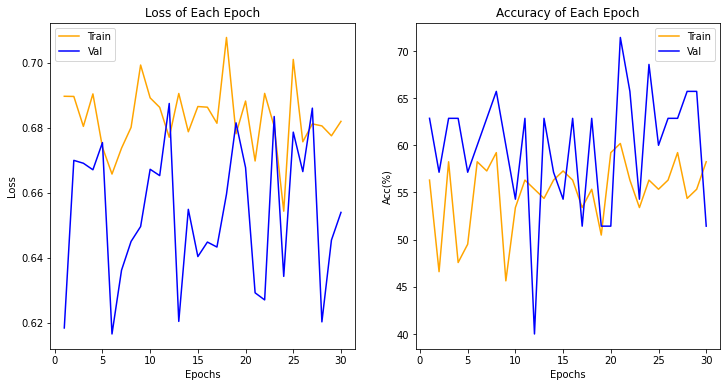

In [29]:
k_to_show = 2
show_result(train_losses[k_to_show-1], val_losses[k_to_show-1], train_accs[k_to_show-1], val_accs[k_to_show-1])

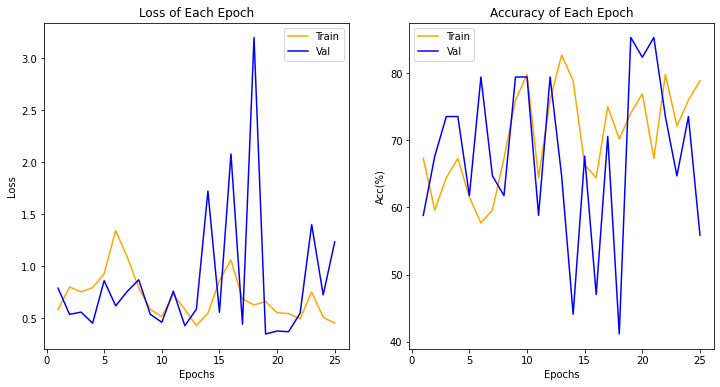

In [ ]:
k_to_show = 3
show_result(train_losses[k_to_show-1], val_losses[k_to_show-1], train_accs[k_to_show-1], val_accs[k_to_show-1])

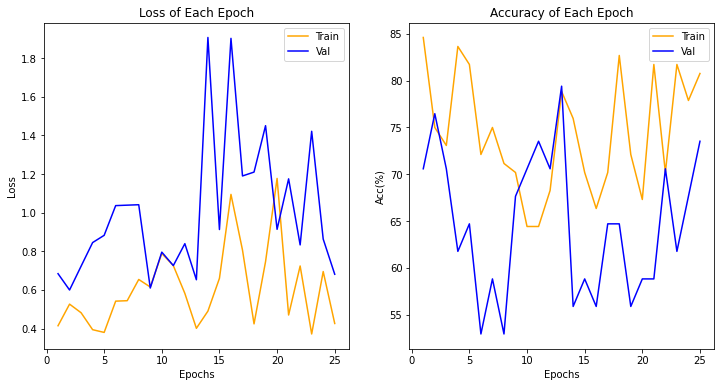

In [ ]:
k_to_show = 4
show_result(train_losses[k_to_show-1], val_losses[k_to_show-1], train_accs[k_to_show-1], val_accs[k_to_show-1])

## evaluate results

In [ ]:
sum_acc = 0.0

for fold, acc in results.items():
    print(f'Fold {fold+1}: {acc}%')
    sum_acc += acc

print(f'Average Results = {sum_acc/len(results)}')
    

Fold 1: 65.71428680419922%
Fold 2: 62.85714340209961%
Fold 3: 64.70588684082031%
Fold 4: 58.82353210449219%
Average Results = 63.025211334228516
